It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/IMBD_sentiment_binary_classification.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/IMBD_sentiment_binary_classification.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [6]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


num_words=10000：只保留出现频率最高的前 10k 个词；其它词会用“未知”标记。

train_data[0] 打印出的是整数序列（不是字符串），每个数字是一个词的 ID。IMDB 自带的是已分词+索引化的数据。

In [7]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

为什么要 +3？
我们预留了 0～3 这四个特殊 ID：

0：<PAD>（填充位）

1：<START>（句子起始）

2：<UNK>（未知词；不在前 10k 里的词）

3：<UNUSED>（占位，通常不用）
所以把原始词表的索引整体右移 3，避免冲突。

int2word 是反向表，用于把数字解回人话。

备注：Keras 官方示例里常见这种右移做法；数据本身通常已经以 1 开头（<START>），所以你看到解码结果的第一词是 <START>。

For transforming an id-sequence to a phrase use get_words

In [8]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i,'<UNK>') for i in sentence])
print(get_words(train_data[0], int2word))
print('Sentiment: ', train_labels[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha


get_words(...)：把一串 ID 转回文本；找不到的用 UNK 兜底。

打印出的句子以START 开头，后面是英文单词；

Sentiment: 1 表示这条评论的情感标签为正面（1=positive，0=negative）。

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [9]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

把文本（字符串）→ ID 序列，并验证能还原出 train_data[0] 的 ID 列表

### Bag of Words Model BoW
We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}`
- **BoW Normalized**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [10]:
from collections import Counter

def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())

text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False)) # norm=False 表示未归一化
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


Counter(sequence)
对分词后的列表计数，得到每个词出现的次数。

norm=True 分支
把次数除以总词数，得到相对频率（归一化的 BoW）。
norm=False 则返回原始计数。

text_example.split()
仅按空格切词，未做小写化/去标点；所以词典可能同时出现 John 与 john 两种写法。

“bag_of_words with indexes …”
把词频字典 {word: count} 映射成 {word_id: count}：

### Document Term Matrix

We need a way to model the documents so that they are all the same length, so that we can use a neural network. For this we are going to use the document term matrix.
- Every document is a vector with the dimension of the vocabulary.
- The position i of the vector corresponds to the word with index i.
- The vector is all zeros except for the BoW word positions, which are filled with the frequency of the corresponding word.


For example:

- D1 = "I like movies",  `{'I': 1, 'like': 1, 'movies': 1}`

- D2 = "I dislike movies",  `{'I': 1, 'dislike': 1, 'movies': 1}`

Then the document-term matrix would be:



   | Doc| I  | like    | dislike   | movies   |
|---:|:-------------|:-----------|:------|:------|
| D1 | 1  | 1       | 0   | 1     |
| D2 | 1  | 0    | 1   | 1     |

$D1 = [1,1,0,1]$

$D2 = [1,0,1,1]$

We convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

Document–Term Matrix（文档-词项矩阵，DTM），也叫 词袋向量。

核心想法

先确定一个词表（vocabulary），比如：["I","like","dislike","movies"]。长度 = 4。

每个文档（句子）都变成长度等于词表大小的向量。

第 i 个位置表示词表中第 i 个词在该文档中的信息（出现/次数/权重）。

这样所有文档都有同样长度，可以直接喂给线性模型或神经网络。

例子（和你截图一致）

D1: "I like movies" → {'I':1,'like':1,'movies':1}

D2: "I dislike movies" → {'I':1,'dislike':1,'movies':1}
按词表顺序 [I, like, dislike, movies]：

D1 → [1, 1, 0, 1]

D2 → [1, 0, 1, 1]

表格里的 1/0 可以是：

Binary：出现=1，不出现=0（你图里的就是这个）

Count：出现次数

TF-IDF：频率×逆文档频率（更常用）

In [11]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words) # 长度 = 词表大小
    bow = get_bag_of_words(sequence, norm)  # {词ID: 频率/次数}
    for w, freq in bow.items():
        if w < num_words:  # 只保留前 num_words 个高频词
            vec[w] = freq  # 在对应位置写入值
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results
#把所有样本堆成矩阵（形状：(样本数, 词表大小)）。

x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

## Define and train a model

Define, compile and fit your NN model

1. You can use the [Functional API](https://keras.io/guides/functional_api/):

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
    layer_1 = layers.Dense(...)(inputs)
```

and the network outputs:
```python
outputs = layers.Dense(...)(previous_layer)
model = keras.Model(inputs=inputs, outputs=outputs)
```

2. Or you can use [Sequential API](https://keras.io/guides/sequential_model/)

```python
model = keras.Sequential(name='example_model')
model.add(layers.Dense(..., input_shape=(8,))
model.add(...
```

First try with only one hidden layer and see the results.

In [12]:
# model = ...

In [13]:
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')  # entrada

l_1 = layers.Dense(128, activation='relu')(inputs)
l_1 = layers.Dropout(0.35)(l_1)

l_2 = layers.Dense(64, activation='relu')(l_1)
l_2 = layers.Dropout(0.35)(l_2)

outputs = layers.Dense(1, activation='sigmoid')(l_2)
# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=2,
                                            verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.25,
                    epochs=4,
                    batch_size=32,
                    callbacks=[es_callback])

Epoch 1/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6765 - loss: 0.6051 - val_accuracy: 0.8792 - val_loss: 0.2986
Epoch 2/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8951 - loss: 0.2673 - val_accuracy: 0.8928 - val_loss: 0.2604
Epoch 3/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9314 - loss: 0.1932 - val_accuracy: 0.8827 - val_loss: 0.2929
Epoch 4/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9475 - loss: 0.1527 - val_accuracy: 0.8917 - val_loss: 0.2765
Epoch 4: early stopping


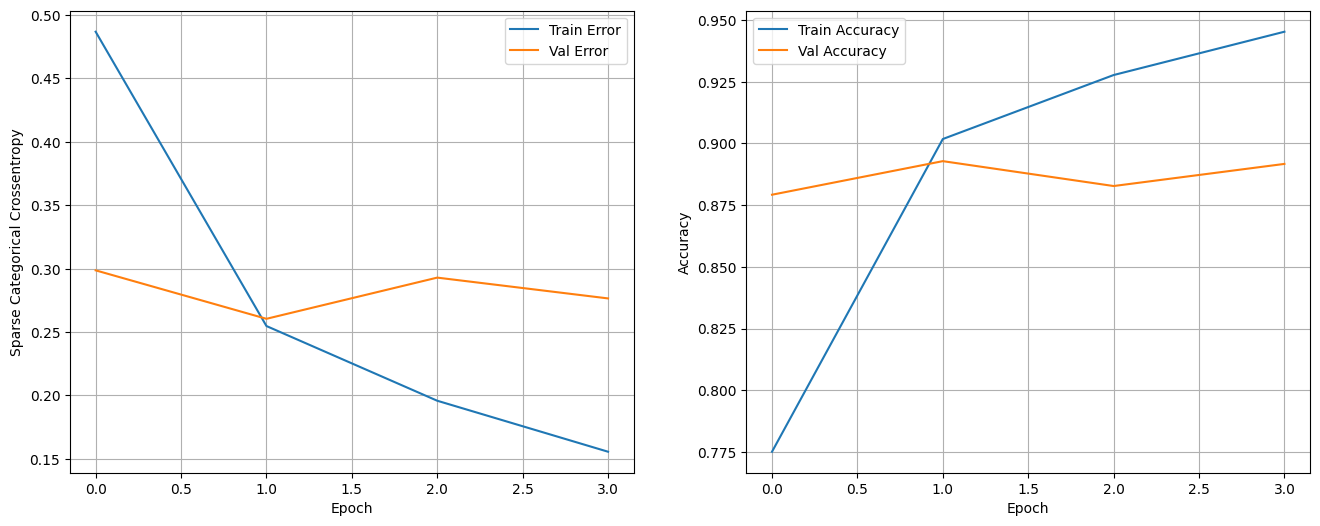

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
def show_loss_accuracy_evolution(hist):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [16]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8827 - loss: 0.3024
Test Loss: 0.30458834767341614
Test Accuracy: 0.8812000155448914


In [17]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test, model, y_test, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predicted : 1, real : 0.0, lenght: 95
<START> it may have been thrilling for an audience in 1946 but the movie is now a bit boring i had a hard time sitting through the whole thing and it was very predictable i mean we know from the beginning of the movie that welles is the nazi war criminal and i'll give you one guess as to whether he is caught and appropriately <UNK> in the end br br not worth watching it's sad that welles only made three movies worth seeing in his long career kane <UNK> and a touch of evil

Predicted : 0, real : 1.0, lenght: 208
<START> the japanese have probably the most sadistic movies around the world and this is one of the strongest examples with a running time at about an hour it contains enough sexual violence and gore to disgust every single sane person on earth even those who are hunting this type of movies three men and a woman are making a porn film after some normally shots which are <UNK> the girl is tied up and t

### Making predictioins with new data

In [18]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the movie is not bad',
           'the movie is not bad I like it'
]
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
predictions = model.predict(x_pred)
for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step

the film was really bad and i am very disappointed
Sentiment:  0.0

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  1.0

this film was just brilliant
Sentiment:  1.0

the movie is not bad
Sentiment:  0.0

the movie is not bad I like it
Sentiment:  0.0


In [19]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]])

### Question 1: Repeat the process with unnormalized bag of words, compare results

In [20]:
x_train = vectorize_sequences(train_data, num_words=num_words, norm=False)
x_test = vectorize_sequences(test_data, num_words=num_words, norm=False)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

In [21]:
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')  # entrada

l_1 = layers.Dense(128, activation='relu')(inputs)
l_1 = layers.Dropout(0.35)(l_1)

l_2 = layers.Dense(64, activation='relu')(l_1)
l_2 = layers.Dropout(0.35)(l_2)

outputs = layers.Dense(1, activation='sigmoid')(l_2)
# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=2,
                                            verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.25,
                    epochs=4,
                    batch_size=32,
                    callbacks=[es_callback])

Epoch 1/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7620 - loss: 0.4844 - val_accuracy: 0.8779 - val_loss: 0.3055
Epoch 2/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9207 - loss: 0.2067 - val_accuracy: 0.8918 - val_loss: 0.2890
Epoch 3/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9512 - loss: 0.1321 - val_accuracy: 0.8888 - val_loss: 0.3094
Epoch 4/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9705 - loss: 0.0811 - val_accuracy: 0.8826 - val_loss: 0.3835
Epoch 4: early stopping


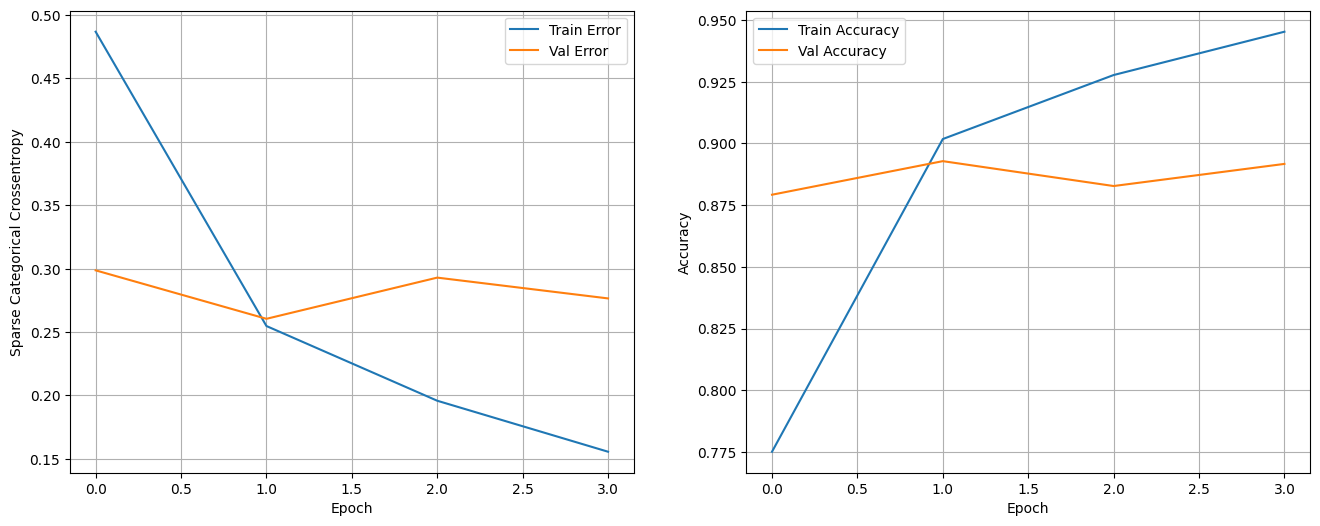

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8723 - loss: 0.4199
Test Loss: 0.4113096594810486
Test Accuracy: 0.8720399737358093


In [23]:
show_loss_accuracy_evolution(hist)
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Question 2: What happens if you reduce the size of the vocabulary `num_words`, compare results

In [24]:
num_words = 6000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


((25000, 6003), (25000,))

In [25]:
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')  # entrada

l_1 = layers.Dense(128, activation='relu')(inputs)
l_1 = layers.Dropout(0.35)(l_1)

l_2 = layers.Dense(64, activation='relu')(l_1)
l_2 = layers.Dropout(0.35)(l_2)

outputs = layers.Dense(1, activation='sigmoid')(l_2)
# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=2,
                                            verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.25,
                    epochs=4,
                    batch_size=32,
                    callbacks=[es_callback])

Epoch 1/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6770 - loss: 0.5930 - val_accuracy: 0.8787 - val_loss: 0.2978
Epoch 2/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8958 - loss: 0.2731 - val_accuracy: 0.8875 - val_loss: 0.2684
Epoch 3/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9244 - loss: 0.2088 - val_accuracy: 0.8842 - val_loss: 0.2781
Epoch 4/4
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9362 - loss: 0.1801 - val_accuracy: 0.8862 - val_loss: 0.2799
Epoch 4: early stopping


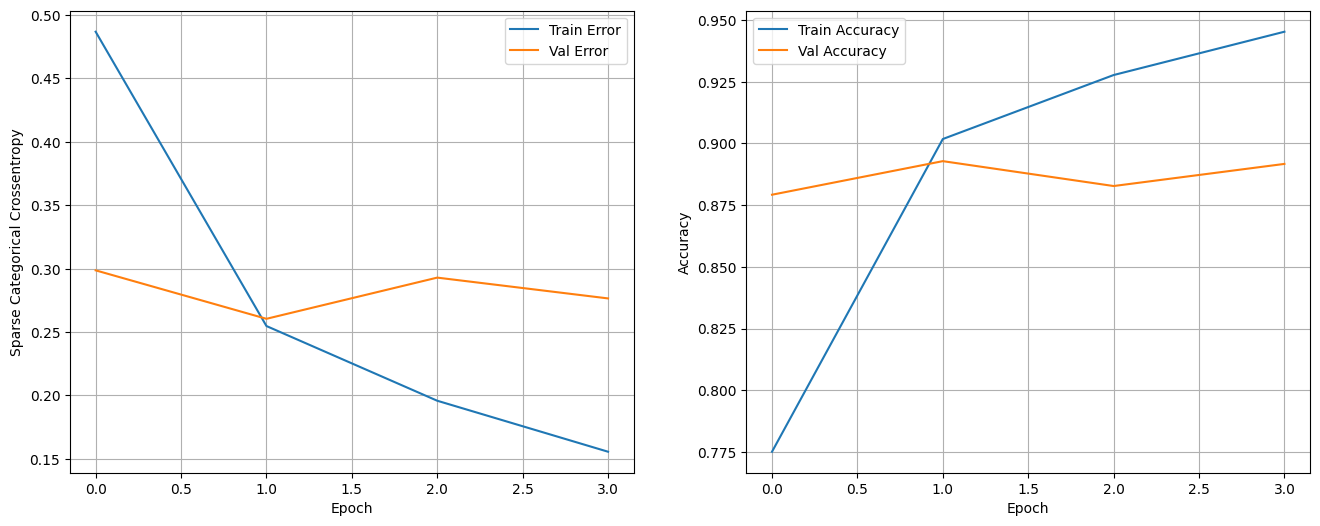

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8826 - loss: 0.3013
Test Loss: 0.2990540564060211
Test Accuracy: 0.8824800252914429


In [27]:
show_loss_accuracy_evolution(hist)
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [28]:
reviews = [
    'the film was really bad and i am very disappointed',
    'The film was very funny entertaining and good we had a great time . brilliant film',
    'this film was just brilliant', 'the movie is not bad',
    'the movie is not bad I like it'
]
sequences = [
    vectorize_text_sentence(review.lower(), word2int) for review in reviews
]

x_pred = vectorize_sequences(sequences, num_words=num_words)
predictions = model.predict(x_pred)
for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

the film was really bad and i am very disappointed
Sentiment:  0.0

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  1.0

this film was just brilliant
Sentiment:  1.0

the movie is not bad
Sentiment:  0.0

the movie is not bad I like it
Sentiment:  0.0


### Compare with other ML algorithms

In [29]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(x_train, y_train)
val_acc = clr.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.72112


In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=5, n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.81252


In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.8432


In [32]:
reviews = []
# training reviews
for ind in range(len(train_data)):
    sentence = train_data[ind]
    sentence_text = get_words(train_data[ind], int2word)
    reviews.append(sentence_text)
print('First training review: ', reviews[0])

First training review:  <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and sho